In [ ]:
%load_ext watermark

In [ ]:
%watermark

In [1]:
import time
notebookstart= time.time()

In [2]:
import os
#import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import r2_score
from typing import Tuple

In [ ]:
%watermark --iversions

## Выствляем переменные

In [4]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [5]:
# номер попытки и название файлов сабмитов
NTRY = 28
NAME_ENS = f'{NTRY}_ens_pca64_sber_nose_iter_2mod'
NAME_CB  = f'{NTRY}_cb_pca64_sber_bord_nose_iter_2mod'
NAME_XGB = f'{NTRY}_xgb_pca64_sber_bord_nose_iter_2mod'
NAME_LGB = f'{NTRY}_lgb_pca64_sber_bord_nose_iter_2mod'

NAME_MN = f'{NTRY}_mn_pca64_sber_nose_iter_2mod'
#xgb_pca64_sber_lags_parse_bord_nose_val_part

In [6]:
# константы по Украине для замены в сабмитах 
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Блок для воспроизводимости результатов

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

# Конкатенация

# Среднее

In [8]:
test      = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'),  usecols = ['document_id', 'distrib_brdr', 'spec',])
cb_test   = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_CB}.csv'))
xgb_test  = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_XGB}.csv'))
lgb_test  = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_LGB}.csv'))

In [9]:
print('before ', test.shape, cb_test.shape, lgb_test.shape, xgb_test.shape)
test = pd.concat([test.reset_index(drop = True),
                   cb_test.reset_index(drop = True),
                   xgb_test.reset_index(drop = True),
                   lgb_test.reset_index(drop = True),
                  ], ignore_index = True, axis = 1)
test_cols = ['document_id', 'distrib_brdr', 'spec',
         'document_id_cb', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb',
         'document_id_xgb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
         'document_id_lgb', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb',
        ]
test.columns  = test_cols


if sum(test.document_id == test.document_id_xgb) != test.shape[0] or \
   sum(test.document_id == test.document_id_lgb) != test.shape[0]:
    print('wtf test')    
    
test.drop(['document_id_cb', 'document_id_xgb', 'document_id_lgb'], axis = 1, inplace = True)
print('after ', test.shape)

before  (3000, 3) (3000, 4) (3000, 4) (3000, 4)
after  (3000, 12)


In [10]:
test.columns

Index(['document_id', 'distrib_brdr', 'spec', 'views_pred_cb', 'depth_pred_cb',
       'frp_pred_cb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
       'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb'],
      dtype='object')

In [1]:
def get_views_mean(inp_row: pd.DataFrame) -> float:
    """
    Подсчет среднего views по строке датафрейма (по сабмитам от трех моделей)
    args:
        inp_row - строка датафрейма по которой считается среднее
    """
    
    #print(inp_row[3], inp_row[6], inp_row[9]) 
    val = np.mean([inp_row[3], inp_row[6], inp_row[9]])
    
    return val


def get_depth_mean(inp_row: pd.DataFrame) -> float:
    """
    Подсчет среднего depth по строке датафрейма (по сабмитам от трех моделей)
    args:
        inp_row - строка датафрейма по которой считается среднее
    """
    #print(inp_row[4], inp_row[7], inp_row[10])
    val = np.mean([inp_row[4], inp_row[7], inp_row[10]])
    
    return val



def get_frp_mean(inp_row: pd.DataFrame) -> float:
    """
    Подсчет среднего frp по строке датафрейма (по сабмитам от трех моделей)
    args:
        inp_row - строка датафрейма по которой считается среднее
    """
    #print(inp_row[5], inp_row[8], inp_row[11])
    val = np.mean([inp_row[5], inp_row[8], inp_row[11]])
    
    return val

NameError: name 'pd' is not defined

In [12]:
subm_mn = pd.DataFrame()
subm_mn[['document_id']] = test[['document_id']]
#subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [13]:
subm_mn['views'] = test.apply(get_views_mean, axis = 1)
subm_mn['depth'] = test.apply(get_depth_mean, axis = 1)
subm_mn['full_reads_percent'] = test.apply(get_frp_mean, axis = 1)

In [14]:
#test.iloc[:5, :].apply(get_views_mean, axis = 1)
#test.iloc[:5, :].apply(get_depth_mean, axis = 1)
#test.iloc[:5, :].apply(get_frp_mean, axis = 1)

In [15]:
doc_id_ukr = test[test.spec == 1].document_id.values
subm_mn.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [16]:
subm_mn.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,13532.855258,1.200854,44.886949
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,6425.980042,1.057802,31.247572
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,10614.593583,1.058591,27.909766
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,5895.831880,1.062631,37.808161
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,99394.128480,1.141441,27.886648


In [18]:
#subm.drop(['distrib_brdr'], inplace = True, axis = 1)
subm_mn.to_csv(os.path.join(DIR_SUBM, f'{NAME_MN}.csv'), index = False)

# Ансамбли

In [8]:
def plot_importance(inp_model, imp_number: Optional[int] = 30, imp_type: Optional[str] = 'weight') -> None:
    """
    Функция построения и отображения важности признаков в модели
    args:
        inp_model - модель из которой берется важности признаков
        inp_number - количество признаков для отображения (опционально, 30)
        imp_type - тип по которому определяется важность признака (опционально, 'weight')
    """
    feature_important = inp_model.get_booster().get_score(importance_type = imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = False)
    data.nlargest(imp_number, columns = "score").plot(kind = 'barh', figsize = (30,16))
    

In [9]:
train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), usecols = ['document_id', 'views', 'depth', 'full_reads_percent', 'distrib_brdr', ])
test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'),  usecols = ['document_id', 'distrib_brdr', 'spec',])

cb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_CB}_train_part.csv'))
cb_test  = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_CB}.csv'))

xgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_XGB}_train_part.csv'))
xgb_test  = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_XGB}.csv'))

lgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_LGB}_train_part.csv'))
lgb_test  = pd.read_csv(os.path.join(DIR_SUBM, f'{NAME_LGB}.csv'))

In [10]:
test.head()

,document_id,distrib_brdr,spec
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,1,0
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,0,0
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,0,0
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,0,0
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,1,0


In [11]:
#train.head(3)
#test.head(3)

In [12]:
print('before ', train.shape, cb_train.shape, lgb_train.shape, xgb_train.shape)
print('before ', test.shape, cb_test.shape, lgb_test.shape, xgb_test.shape)
train = pd.concat([train.reset_index(drop = True),
                   cb_train.reset_index(drop = True),
                   xgb_train.reset_index(drop = True),
                   lgb_train.reset_index(drop = True),
                  ], ignore_index = True, axis = 1)

test = pd.concat([test.reset_index(drop = True),
                   cb_test.reset_index(drop = True),
                   xgb_test.reset_index(drop = True),
                   lgb_test.reset_index(drop = True),
                  ], ignore_index = True, axis = 1)

train_cols = ['document_id', 'views', 'depth', 'full_reads_percent', 'distrib_brdr',
         'document_id_cb', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb',
         'document_id_xgb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
         'document_id_lgb', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb',
        ]
test_cols = ['document_id', 'distrib_brdr', 'spec',
         'document_id_cb', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb',
         'document_id_xgb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
         'document_id_lgb', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb',
        ]
train.columns = train_cols
test.columns  = test_cols


if sum(train.document_id == train.document_id_xgb) != train.shape[0] or \
   sum(train.document_id == train.document_id_lgb) != train.shape[0]:
    print('wtf train')
    
if sum(test.document_id == test.document_id_xgb) != test.shape[0] or \
   sum(test.document_id == test.document_id_lgb) != test.shape[0]:
    print('wtf test')    
    
train.drop(['document_id_cb', 'document_id_xgb', 'document_id_lgb'], axis = 1, inplace = True)
test.drop(['document_id_cb', 'document_id_xgb', 'document_id_lgb'], axis = 1, inplace = True)
   
print('after ', train.shape)
print('after ', test.shape)

before  (6981, 5) (6981, 4) (6981, 4) (6981, 4)
before  (3000, 3) (3000, 4) (3000, 4) (3000, 4)
after  (6981, 14)
after  (3000, 12)


In [13]:
#train.columns[5:]
test.columns

Index(['document_id', 'distrib_brdr', 'spec', 'views_pred_cb', 'depth_pred_cb',
       'frp_pred_cb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
       'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb'],
      dtype='object')

In [14]:
test.head(5)

,document_id,distrib_brdr,spec,views_pred_cb,depth_pred_cb,frp_pred_cb,views_pred_xgb,depth_pred_xgb,frp_pred_xgb,views_pred_lgb,depth_pred_lgb,frp_pred_lgb
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,1,0,14373.004863,1.204846,43.721250,15157.972656,1.190166,47.311020,11067.588253,1.207550,43.628577
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,0,0,5978.932869,1.058283,33.748877,6112.205078,1.055791,29.454018,7186.802178,1.059333,30.539822
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,0,0,8824.021815,1.057760,27.853561,11578.751953,1.060226,26.978979,11441.006980,1.057789,28.896757
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,0,0,7391.985447,1.063639,35.863349,5158.374512,1.063956,38.677151,5137.135680,1.060298,38.883983
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,1,0,117443.086763,1.143752,27.600877,99294.867188,1.134205,26.597013,81444.431489,1.146364,29.462053


# нормализуем

In [15]:
train_cols = train.columns[5:]
print(train_cols)

Index(['views_pred_cb', 'depth_pred_cb', 'frp_pred_cb', 'views_pred_xgb',
       'depth_pred_xgb', 'frp_pred_xgb', 'views_pred_lgb', 'depth_pred_lgb',
       'frp_pred_lgb'],
      dtype='object')


In [16]:
scaler_start = preprocessing.StandardScaler()  #Standardize features by removing the mean and scaling to unit variance.
scaler_end = preprocessing.StandardScaler()  #Standardize features by removing the mean and scaling to unit variance.

scaler_start.fit(train[train.distrib_brdr == 1][train_cols])
scaler_end.fit(train[train.distrib_brdr == 0][train_cols])

train.loc[train.query('distrib_brdr == 1').index, train_cols] = scaler_start.transform(train[train.distrib_brdr == 1][train_cols])
test.loc[test.query('distrib_brdr == 1').index, train_cols]  = scaler_start.transform(test[test.distrib_brdr == 1][train_cols])

train.loc[train.query('distrib_brdr == 0').index, train_cols] = scaler_end.transform(train[train.distrib_brdr == 0][train_cols])
test.loc[test.query('distrib_brdr == 0').index, train_cols]  = scaler_end.transform(test[test.distrib_brdr == 0][train_cols])

In [17]:
#!!!!!!!!! нормализовать предикты
#!!!!!!!!! сделать предикты

In [18]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    """
    Функция для расчета дополнительной метрики R2 в cv.
    
    args:
        y_pred - предсказанные значения
        y_true - целевые значения
    return:
        Tuple
            str - имя метрики для отображения в cv scores
            float - значение метрики
    """
    
    return 'r2', r2_score(y_true.get_label(), y_pred)

# views

In [19]:
cv_ntrees = 100

xgb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 4, 
    #'lambda': 10,
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
#dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['views']])
#dval   = xgb.DMatrix(val[train.columns[4:]], label=val[['views']])

In [20]:
def get_model(inp_df: pd.DataFrame, inp_params: Dict, target: str):
    """
    Обучение модели с выбором оптимального количества итераци по cv на 5 фолдов
    по метрике rmse-mean на валидационных фолдах
    args:
        inp_df - датасет для обучения
        inp_params - параметры модели
        target - имя колонки целевого значения
    return:
        обученная модель XGBRegressor
    """
    
    dtrain = xgb.DMatrix(inp_df[num_cols], label = inp_df[[target]])
    
    scores = xgb.cv(inp_params, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
    
    print(scores[scores['test-rmse-mean'] == scores['test-rmse-mean'].min()][:1].to_string())
    niters = scores['test-rmse-mean'].argmin()
    
    model = XGBRegressor(n_estimators=niters, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

    model.fit(inp_df[num_cols], inp_df[target], 
                    verbose=False
                   )
    
    return model

In [21]:
%%time
model_views_start = get_model(train[train.distrib_brdr == 1], xgb_params_views, 'views')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
75      2900.732836       48.363055    17370.268733   20762.182095       0.998787      0.000155      0.942307     0.095894
Wall time: 2.28 s


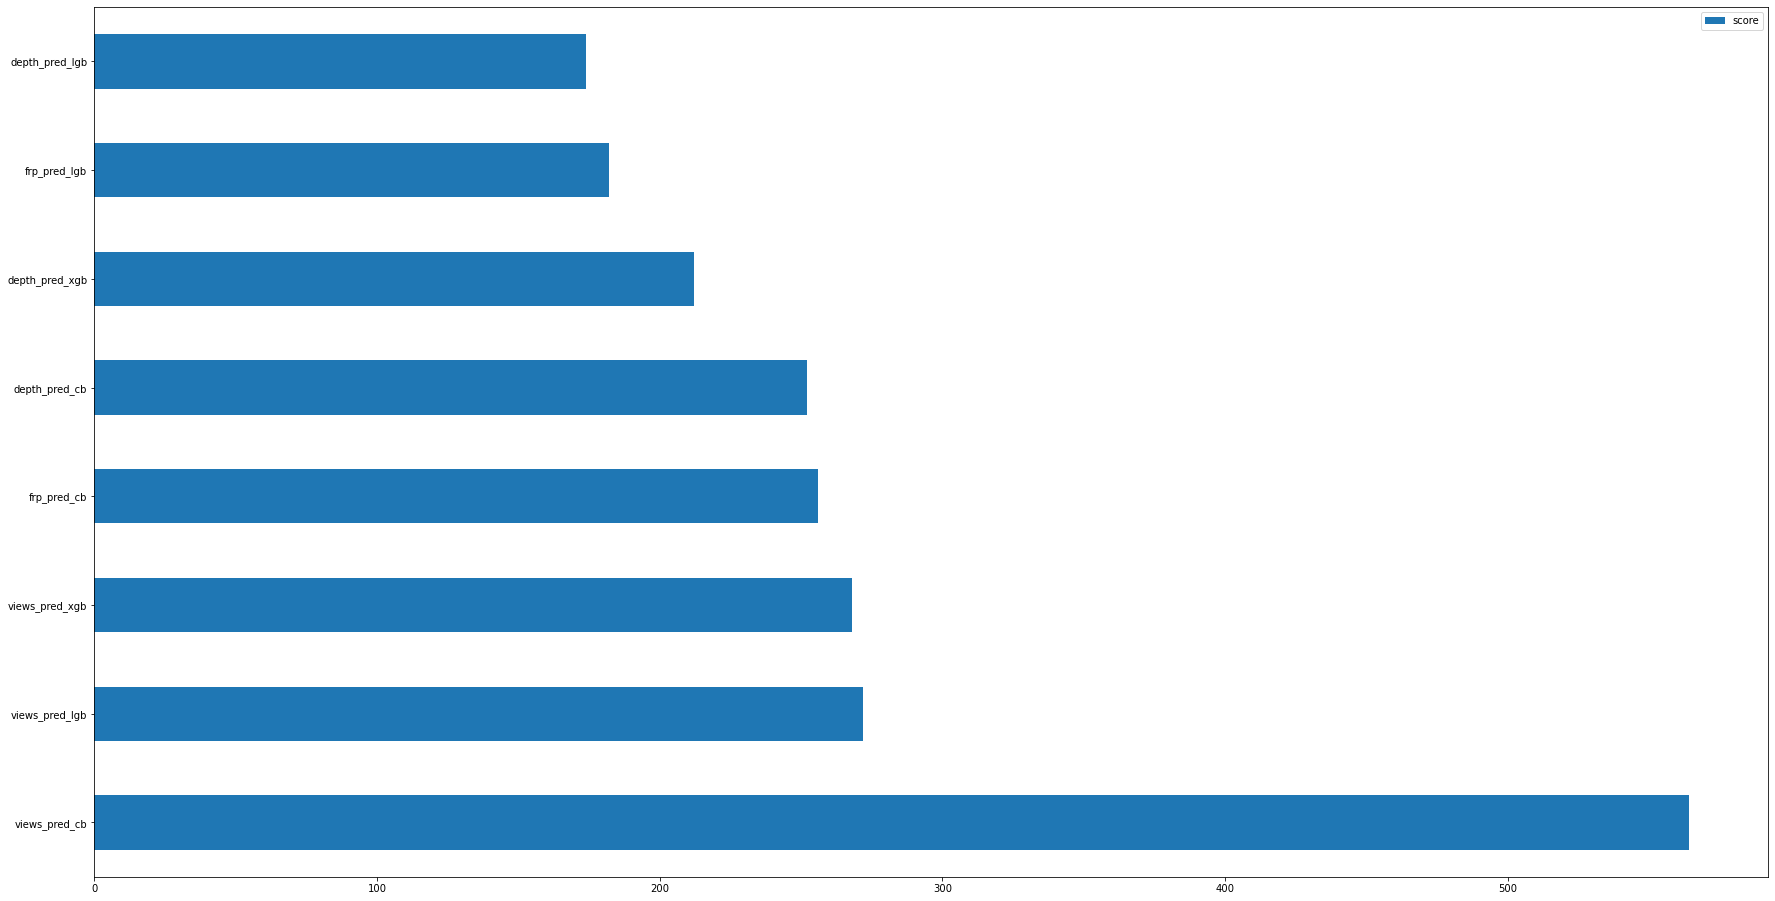

In [22]:
plot_importance(model_views_start, 8, 'weight')

In [23]:
%%time
model_views_end = get_model(train[train.distrib_brdr == 0], xgb_params_views, 'views')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
22      2268.699086       29.683326     2986.957637     424.832847       0.976709      0.000448      0.959297     0.006397
Wall time: 2.25 s


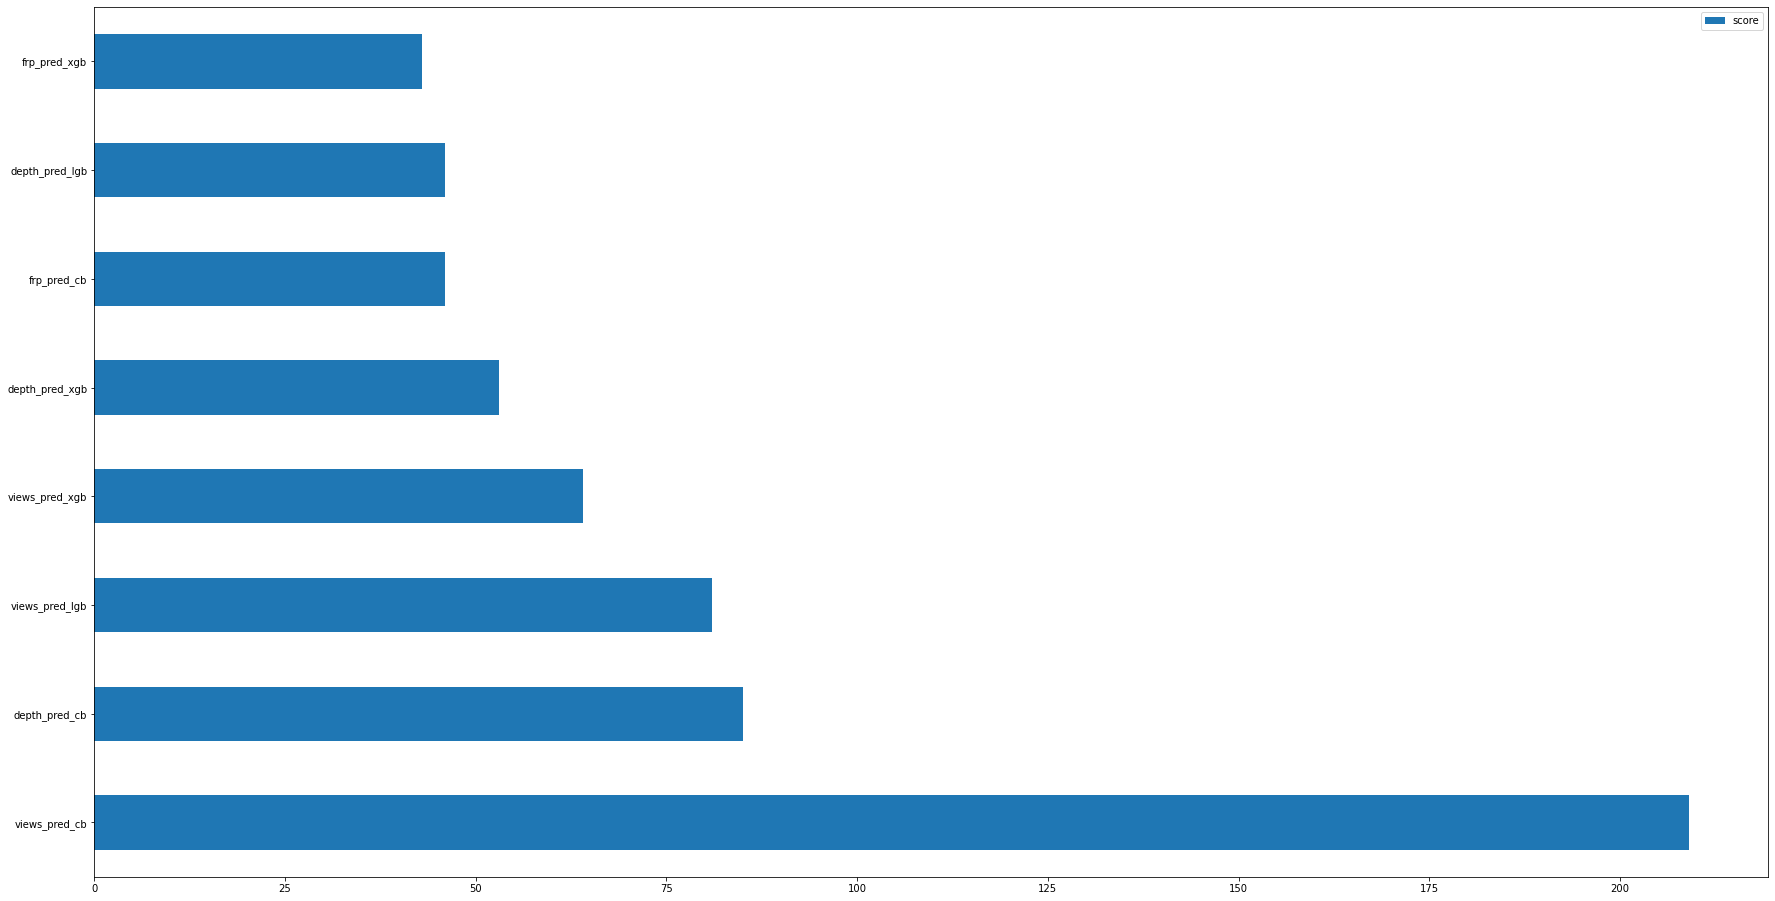

In [24]:
plot_importance(model_views_end, 8, 'weight')

# depth

In [25]:
#cv_ntrees = 100

xgb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 4, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
#dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['depth']])

In [26]:
%%time
model_depth_start = get_model(train[train.distrib_brdr == 1], xgb_params_depth, 'depth')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
51          0.00494        0.000075        0.007554       0.001208       0.991034      0.000703      0.978326     0.003114
Wall time: 2.08 s


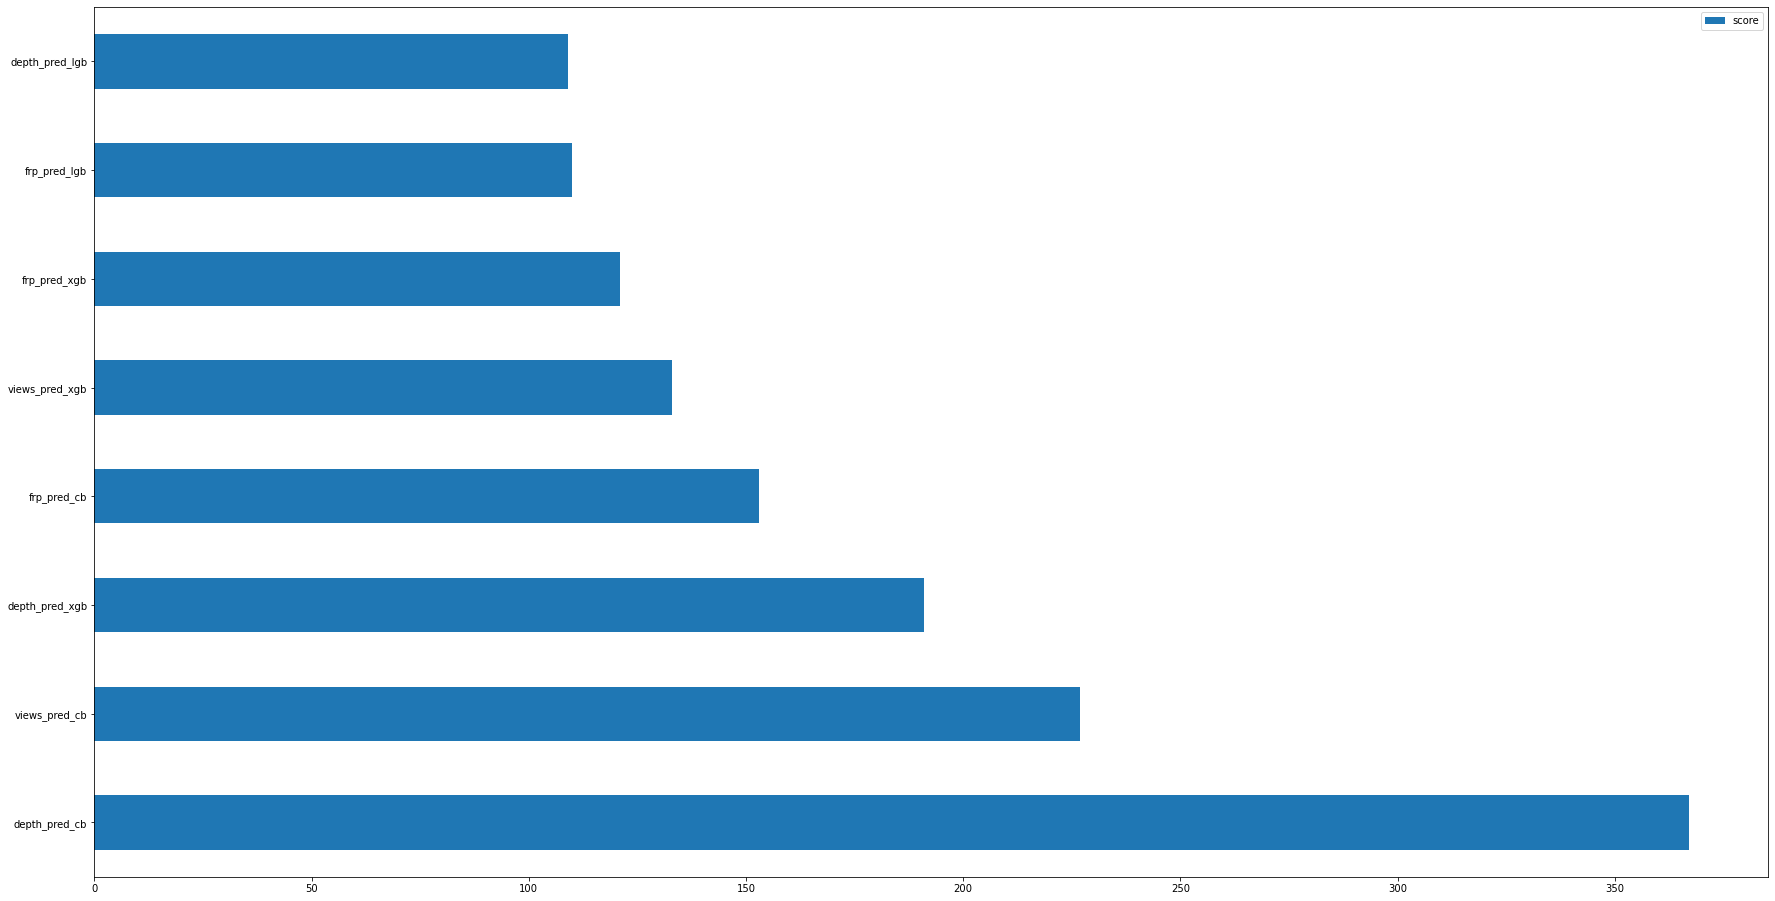

In [27]:
plot_importance(model_depth_start, 8, 'weight')

In [28]:
%%time
model_depth_end = get_model(train[train.distrib_brdr == 0], xgb_params_depth, 'depth')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
66         0.002137        0.000017        0.004746       0.002571       0.990189       0.00052      0.947938     0.044401
Wall time: 2.37 s


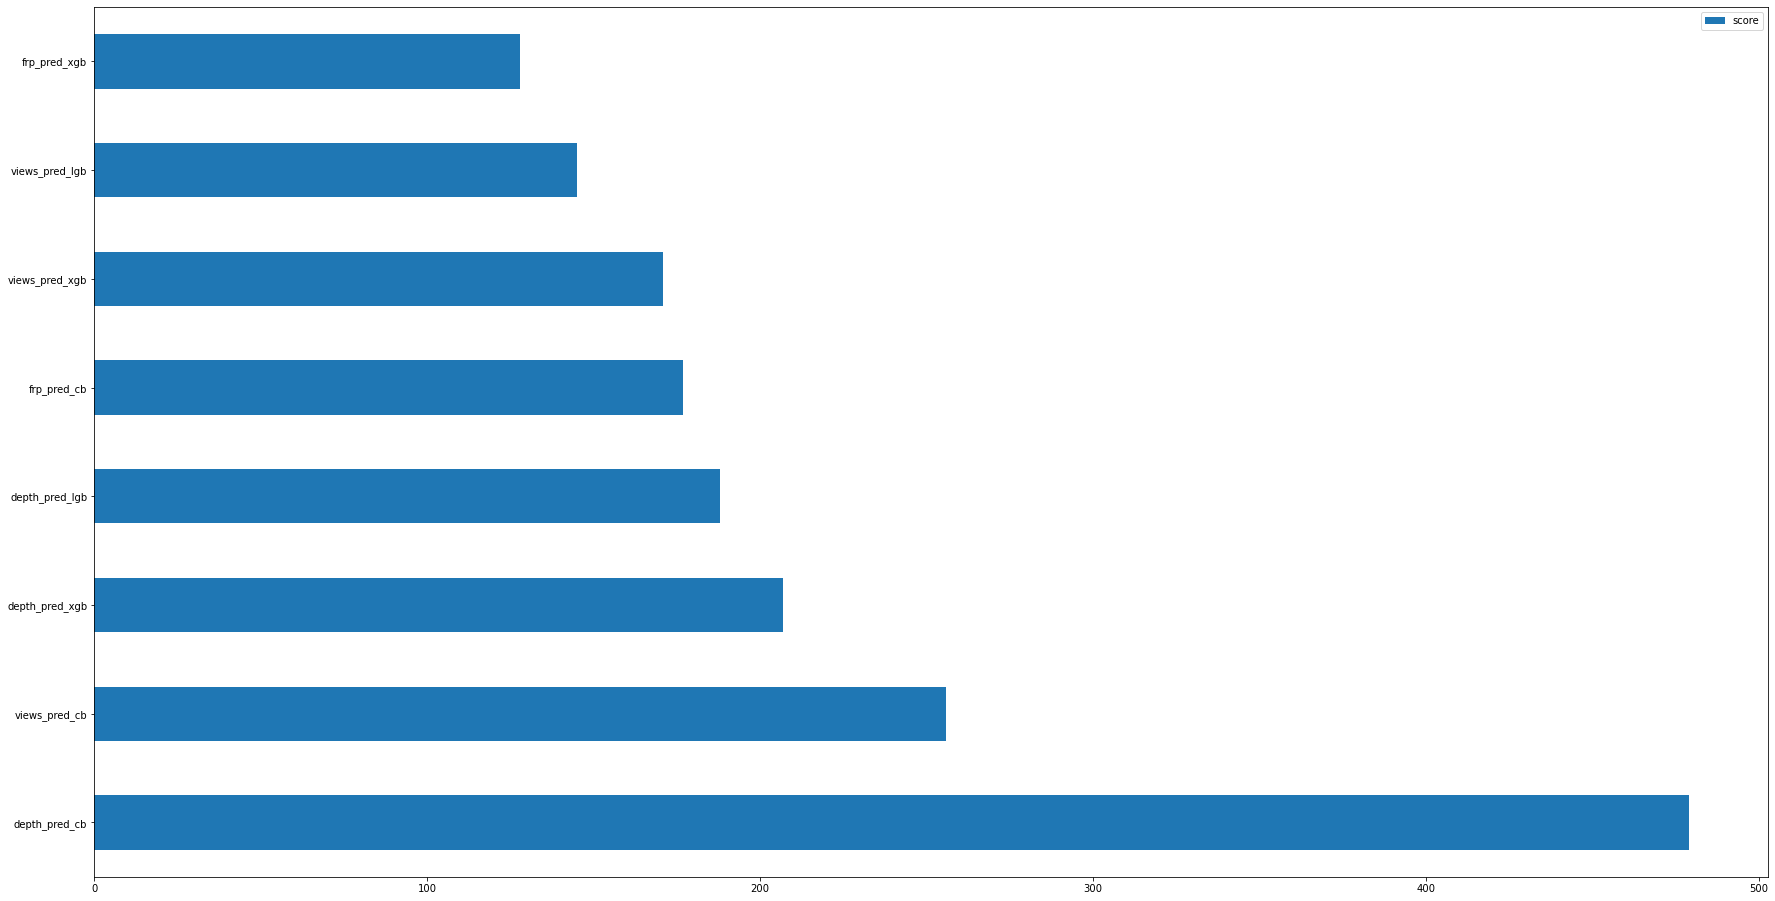

In [29]:
plot_importance(model_depth_end, 8, 'weight')

# full_reads_percent

In [30]:
#cv_ntrees = 100

xgb_params_frp = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 4, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
#dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['full_reads_percent']])

In [31]:
%%time
model_frp_start = get_model(train[train.distrib_brdr == 1], xgb_params_frp, 'full_reads_percent')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
39         1.154751        0.007179        1.556266       0.030244       0.987982      0.000187      0.978145     0.000949
Wall time: 2.07 s


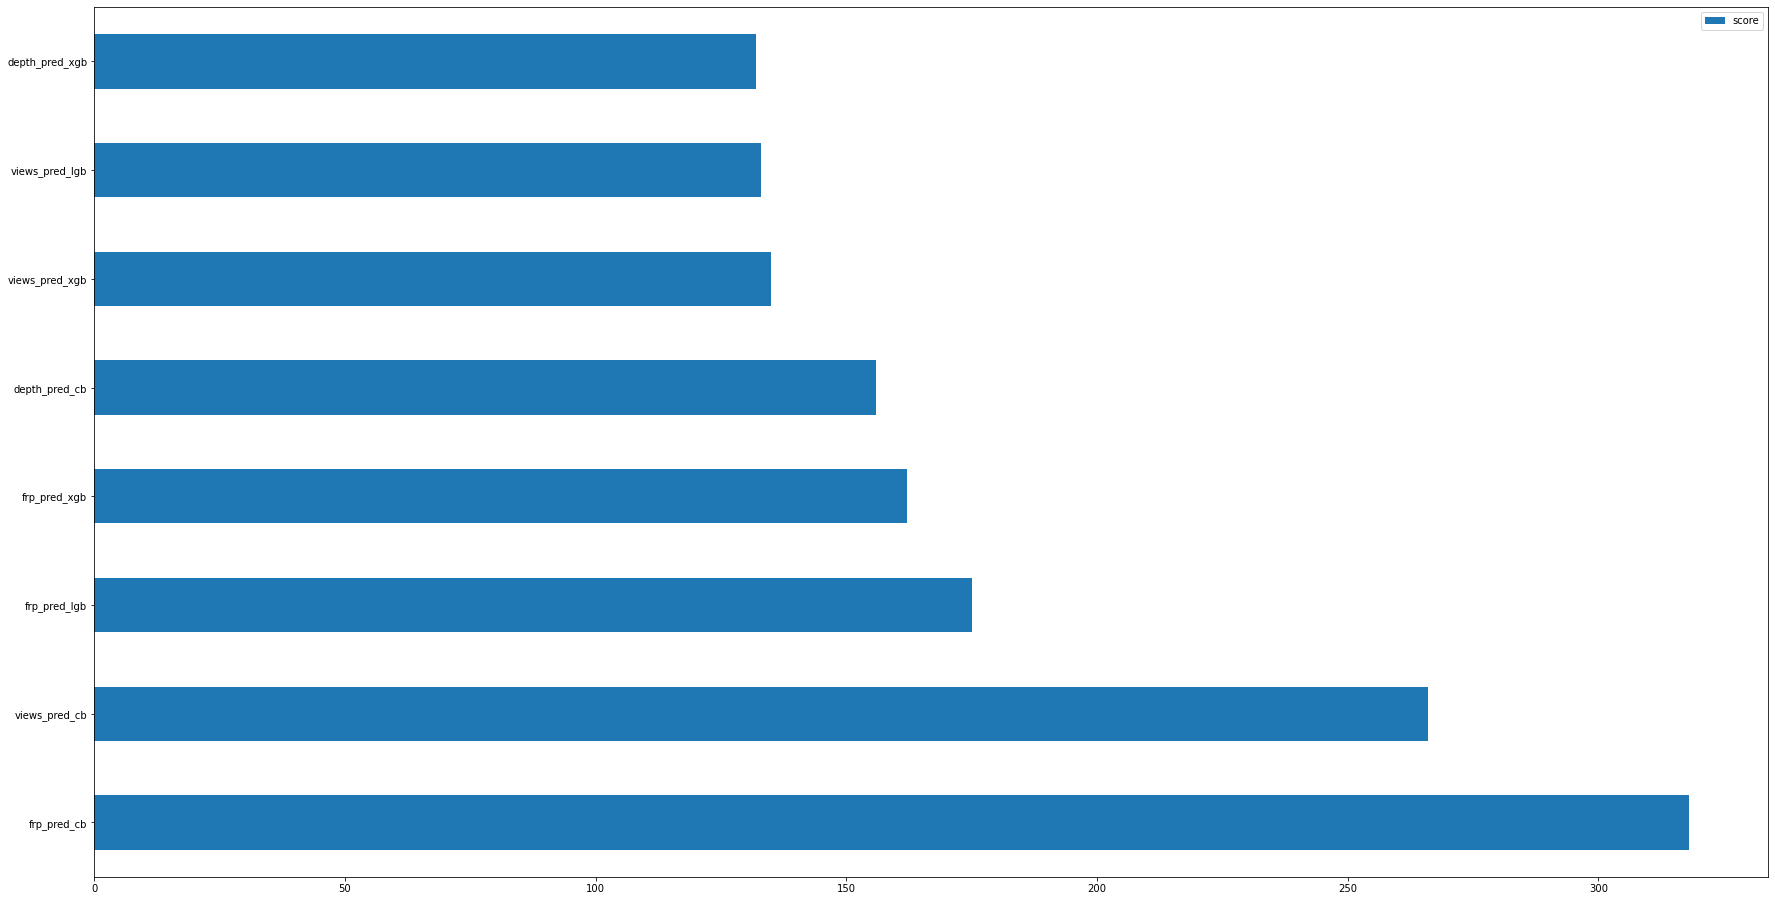

In [32]:
plot_importance(model_frp_start, 8, 'weight')

In [33]:
%%time
model_frp_end = get_model(train[train.distrib_brdr == 0], xgb_params_frp, 'full_reads_percent')

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  train-r2-mean  train-r2-std  test-r2-mean  test-r2-std
32         1.620557        0.012362        2.014469       0.024523       0.971915      0.000664      0.956496     0.002412
Wall time: 2.3 s


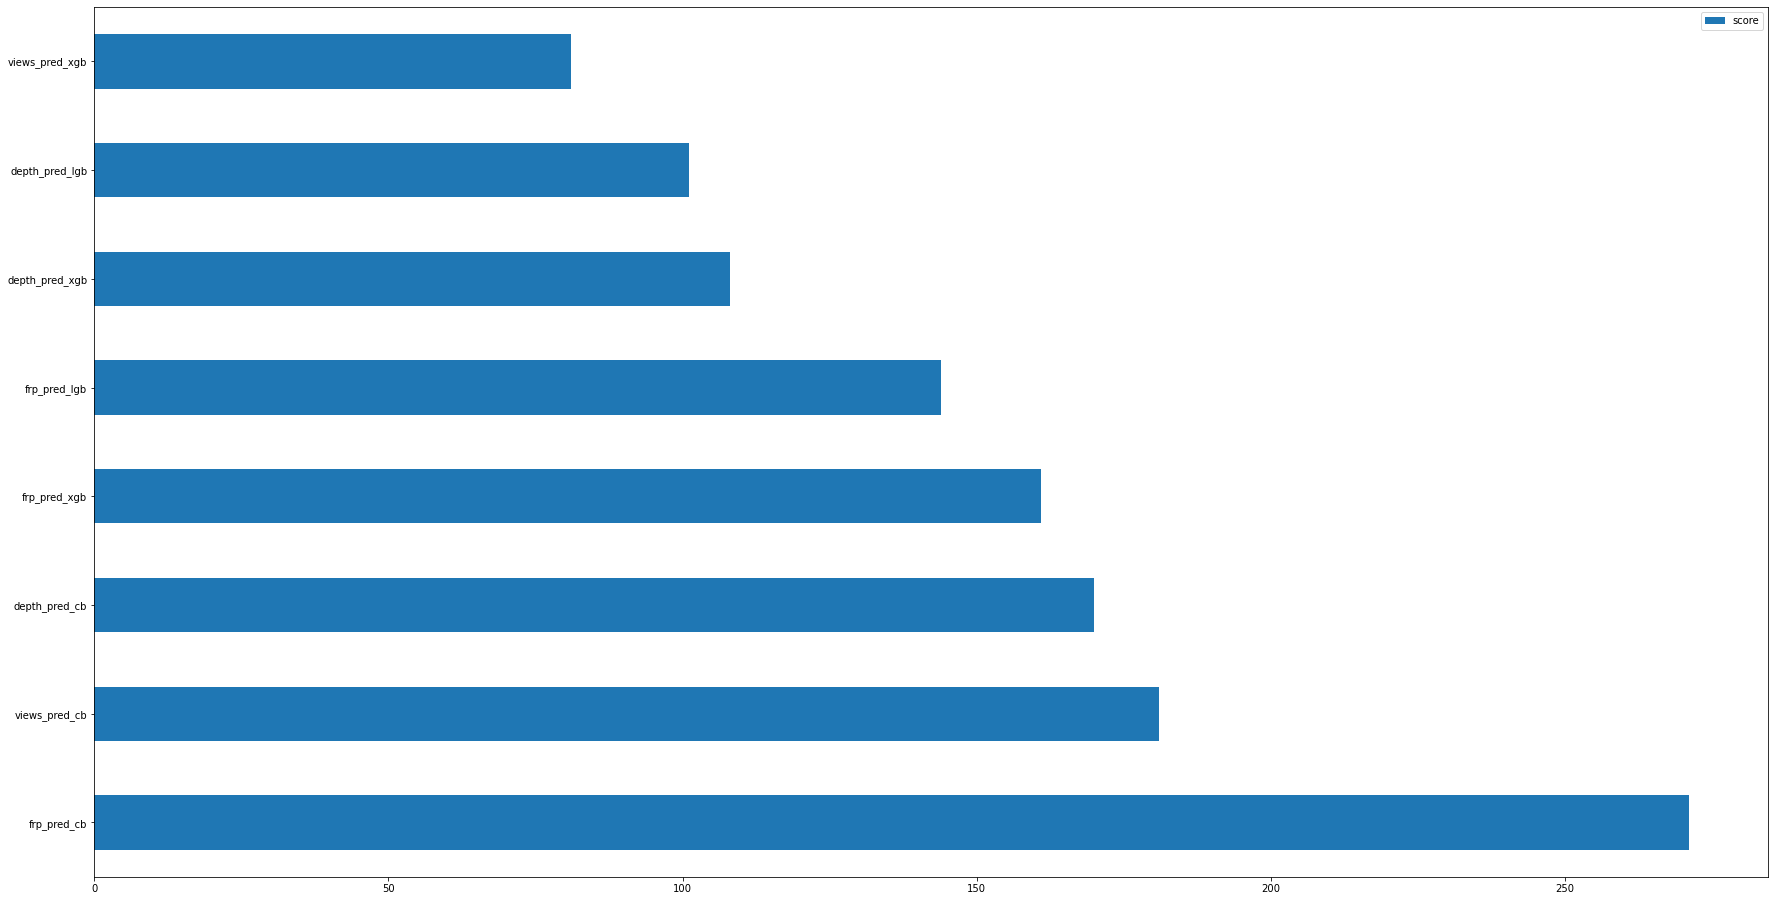

In [34]:
plot_importance(model_frp_end, 8, 'weight')

# Сохраняем финальные модели

In [35]:
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_v_start.json'), 
                          )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_v_end.json'), 
                          )

model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_d_start.json'), 
                          )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_d_end.json'), 
                          )

model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_f_start.json'), 
                        )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME_ENS}_f_end.json'), 
                        )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:722: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


# Делаем предсказание

In [36]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [37]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(test[test.distrib_brdr == 1][train_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(test[test.distrib_brdr == 0][train_cols])
print(sum(subm.views.isna()), ' Nan in views')

0  Nan in views


In [38]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(test[test.distrib_brdr == 1][train_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(test[test.distrib_brdr == 0][train_cols])
print(sum(subm.depth.isna()), ' Nan in depth')

0  Nan in depth


In [39]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(test[test.distrib_brdr == 1][train_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(test[test.distrib_brdr == 0][train_cols])
print(sum(subm.full_reads_percent.isna()), ' Nan in full_reads_percent')

0  Nan in full_reads_percent


In [40]:
doc_id_ukr = test[test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2392522.75,1.64968,9.86407
1440,2392522.75,1.64968,9.86407
2645,2392522.75,1.64968,9.86407


In [41]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [42]:
subm.head()

,document_id,distrib_brdr,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,1,10657.481445,1.213818,42.762196
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,0,5636.290039,1.059606,36.314007
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,0,7838.027832,1.057433,26.934601
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,0,7090.810547,1.063450,32.700157
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,1,103959.609375,1.149572,26.469128


In [43]:
subm.drop(['distrib_brdr'], inplace = True, axis = 1)
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME_ENS}.csv'), index = False)

In [45]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,10657.481445,1.213818,42.762196
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5636.290039,1.059606,36.314007
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,7838.027832,1.057433,26.934601
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,7090.810547,1.063450,32.700157
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,103959.609375,1.149572,26.469128


In [44]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 0.38 Minutes


In [11]:
#plot_corrc(train, ['views'], ['views_pred_cb'])
#plot_corrc(train, ['views'], ['views_pred_xgb'])
#plot_corrc(train, ['views'], ['views_pred_lgb'])

In [ ]:
#plot_corrc(train, ['depth'], ['depth_pred_cb'])
#plot_corrc(train, ['depth'], ['depth_pred_xgb'])
#plot_corrc(train, ['depth'], ['depth_pred_lgb'])